In [49]:
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
from torchvision import datasets
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import random
import time
import os

In [50]:
SAMPLE_SIZE = 5000
NUM_LABELS = 10

In [51]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
# Load data
dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

# Normalize images
all_images = torch.stack([dataset[i][0] for i in range(len(dataset))])
all_labels = torch.tensor([dataset[i][1] for i in range(len(dataset))])

cifar10_mean = np.array(all_images.mean(dim=(0, 2, 3)))
cifar10_std = np.array(all_images.std(dim=(0, 2, 3)))

mean_tensor = torch.tensor(cifar10_mean).view(1, 3, 1, 1)
std_tensor = torch.tensor(cifar10_std).view(1, 3, 1, 1)

normalized_images = (all_images - mean_tensor) / std_tensor

# Subset first 5k samples
images = normalized_images[:SAMPLE_SIZE]  # Use normalized images
subset_labels = all_labels[:SAMPLE_SIZE]

# Convert labels to one-hot encoding for MSE loss (CIFAR-10 has 10 classes)
one_hot_labels = torch.zeros(subset_labels.size(0), NUM_LABELS, device=subset_labels.device)
one_hot_labels.scatter_(1, subset_labels.unsqueeze(1), 1)

# Use one_hot_labels for MSE loss
labels = one_hot_labels

Files already downloaded and verified


In [62]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, num_labels, activation=nn.Tanh):
        super(FullyConnectedNet, self).__init__()

        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.num_labels = num_labels
        self.activation = activation

        layers = [nn.Flatten()]
        in_size = input_size

        for _ in range(num_hidden_layers):
            layers += [nn.Linear(in_size, hidden_layer_size), activation()]
            in_size = hidden_layer_size

        layers.append(nn.Linear(in_size, num_labels))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [63]:
def compute_sharpness(model, criterion, images, labels,
                      iters: int = 20, tol: float = 1e-3,
                      subsample: int | None = 1024, damping: float = 0.0) -> float:
    """
    Estimates λ_max(H) (sharpness) of the loss at current model parameters via
    power iteration with Hessian–vector products (Pearlmutter trick).

    Args
    ----
    model      : nn.Module (params require_grad=True)
    criterion  : callable(logits, targets) -> scalar loss (mean reduction)
    images     : tensor [N, ...] on correct device
    labels     : tensor [N] on correct device
    iters      : power-iteration steps (15–25 typical)
    tol        : relative convergence tolerance
    subsample  : if not None, randomly sample this many examples for speed
    damping    : computes eigenvalues of (H + damping * I)

    Returns
    -------
    float: estimated largest eigenvalue (sharpness)
    """
    was_training = model.training
    model.eval()  # stabilize stats (esp. BN/Dropout)

    # ---- choose subset (for speed/memory) ----
    if subsample is not None and images.size(0) > subsample:
        idx = torch.randperm(images.size(0), device=images.device)[:subsample]
        xb, yb = images[idx], labels[idx]
    else:
        xb, yb = images, labels

    params = [p for p in model.parameters() if p.requires_grad]
    n = sum(p.numel() for p in params)
    if n == 0:
        if was_training: model.train()
        return 0.0

    # ---- forward with graph for second-order autodiff ----
    # Important: no torch.no_grad() here
    model.zero_grad(set_to_none=True)
    logits = model(xb)
    loss = criterion(logits, yb)

    # ∇ℓ with graph so we can differentiate it again
    grads = torch.autograd.grad(loss, params, create_graph=True, retain_graph=True)
    g_flat = torch.cat([gi.reshape(-1) for gi in grads])

    # init v ~ unit vector
    with torch.no_grad():
        v = torch.randn(n, device=g_flat.device)
        v /= (v.norm() + 1e-12)

    lam_prev = None
    for _ in range(iters):
        # H v = ∇[(∇ℓ)·v]
        gv = (g_flat * v).sum()
        Hv_parts = torch.autograd.grad(gv, params, retain_graph=True)
        Hv = torch.cat([h.reshape(-1) for h in Hv_parts])
        if damping != 0.0:
            Hv = Hv + damping * v

        with torch.no_grad():
            Hv_norm = Hv.norm()
            if Hv_norm == 0 or torch.isnan(Hv_norm):
                lam = 0.0
                break
            v = Hv / (Hv_norm + 1e-12)
            lam = torch.dot(v, Hv).item()

            if lam_prev is not None:
                if abs(lam - lam_prev) / (abs(lam_prev) + 1e-12) < tol:
                    break
            lam_prev = lam

    # cleanup and restore mode
    del grads, g_flat, logits, loss
    if was_training: model.train()
    return float(lam_prev if lam_prev is not None else lam)

In [64]:
def setup_output_files(output_dir="output"): 

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    metadata_path = os.path.join(output_dir, "metadata.csv")
    output_data_path = os.path.join(output_dir, "output.csv")

    if os.path.exists(metadata_path):
            metadata = pd.read_csv(metadata_path)
    else:
        metadata = pd.DataFrame({
            "model_id": pd.Series(dtype="int"),
            "model_type": pd.Series(dtype="str"),
            "num_hidden_layers": pd.Series(dtype="int"),
            "hidden_layers_size": pd.Series(dtype="int"),
            "activation_function": pd.Series(dtype="str"),
            "optimizer": pd.Series(dtype="str"),
            "momentum": pd.Series(dtype="int"),
            "learning_rate": pd.Series(dtype="float"),
            "num_epochs": pd.Series(dtype="int"),
            "train_time": pd.Series(dtype="float")
        })

    if os.path.exists(output_data_path):
        output_data = pd.read_csv(output_data_path)
    else:
        output_data = pd.DataFrame({
            "model_id": pd.Series(dtype="int"),
            "loss": pd.Series(dtype="float"),
            "sharpness": pd.Series(dtype="float")
        })

    return metadata, output_data

In [65]:
def load_output_files(output_dir="output"):
    metadata_path = os.path.join(output_dir, "metadata.csv")
    output_data_path = os.path.join(output_dir, "output.csv")

    metadata = pd.read_csv(metadata_path)
    output_data = pd.read_csv(output_data_path)

    return metadata, output_data

In [66]:
def save_output_files(metadata, output_data, output_dir="output"):

    metadata_path = os.path.join(output_dir, "metadata.csv")
    output_data_path = os.path.join(output_dir, "output.csv")
    
    metadata.to_csv(metadata_path, index=False)
    output_data.to_csv(output_data_path, index=False)

In [67]:
def train_model(model, optimizer, criterion, learning_rate, num_epochs, images, labels, num_sharpness_computations=100):
    
    optimizer.param_groups[0]['lr'] = learning_rate

    model = model.to(device)
    images = images.to(device)
    labels = labels.to(device)

    train_losses = np.empty(num_epochs)
    sharps = np.full(num_epochs, np.nan)

    model.train()

    print(f"Model: {model.__class__.__name__}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Number of Epochs: {num_epochs}")
    if optimizer.__class__.__name__ == 'SGD': 
        print(f"Momentum: {optimizer.defaults['momentum']}")
    else:
        print(f"Momentum: None")

    start_time = time.time()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses[epoch] = loss.item()
        
        if (epoch + 1) % (num_epochs // num_sharpness_computations) == 0 or epoch == 0:
            sharpness = compute_sharpness(model, criterion, images, labels, iters=10, 
                                    subsample=256)
            sharps[epoch] = sharpness
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Sharpness: {sharpness}")
            
    end_time = time.time()

    metadata, output_data, = setup_output_files("output")
    model_id = metadata.shape[0] + 1
    
    metadata.loc[metadata.shape[0]] ={
        "model_id": model_id,
        "model_type": model.__class__.__name__,
        "num_hidden_layers": model.num_hidden_layers,
        "hidden_layers_size": model.hidden_layers_size,
        "activation_function": model.activation_funciton,
        "optimizer": optimizer.__class__.__name__,
        "momentum" : optimizer.defaults['momentum'] if optimizer.__class__.__name__ == 'SGD' else 0,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "train_time": end_time - start_time,
    }

    output_data = pd.concat([output_data, pd.DataFrame({
        "model_id": np.ones_like(train_losses) * model_id,
        "loss": train_losses,
        "sharpness": sharps
    })], ignore_index=True)

    save_output_files(metadata, output_data, output_dir="output")
    print("")

In [68]:
input_size = np.prod(all_images.shape[1:])
num_hidden_layers = 3
hidden_layer_size = 1000

learning_rates = [2/20, 2/50, 2/80, 2/110]
momentums = [0] # [0.6, 0.7, 0.8, 0.9]
num_epochs = 5000
num_sharpness_computations = 100
    
for momentum in momentums:
    for lr in learning_rates:
        model = FullyConnectedNet(input_size, num_hidden_layers, hidden_layer_size, NUM_LABELS)
        train_model(model=model, 
                    optimizer=torch.optim.SGD(model.parameters(), momentum = momentum), 
                    criterion=nn.MSELoss(), 
                    num_epochs=num_epochs,
                    learning_rate=lr,
                    images=images, 
                    labels=labels,
                    num_sharpness_computations=num_sharpness_computations
        )

Model: FullyConnectedNet
Optimizer: SGD
Learning Rate: 0.1
Number of Epochs: 5000
Momentum: 0
Epoch [1/5000], Loss: 0.1086, Sharpness: 6.320305824279785
Epoch [50/5000], Loss: 0.0811, Sharpness: 6.42317008972168
Epoch [100/5000], Loss: 0.0787, Sharpness: 6.9106268882751465
Epoch [150/5000], Loss: 0.0774, Sharpness: 7.635837078094482
Epoch [200/5000], Loss: 0.0763, Sharpness: 6.9246673583984375
Epoch [250/5000], Loss: 0.0755, Sharpness: 8.149604797363281
Epoch [300/5000], Loss: 0.0746, Sharpness: 8.040704727172852
Epoch [350/5000], Loss: 0.0739, Sharpness: 7.523216247558594
Epoch [400/5000], Loss: 0.0732, Sharpness: 9.129982948303223
Epoch [450/5000], Loss: 0.0725, Sharpness: 8.270734786987305
Epoch [500/5000], Loss: 0.0718, Sharpness: 9.67652416229248
Epoch [550/5000], Loss: 0.0711, Sharpness: 10.118167877197266
Epoch [600/5000], Loss: 0.0704, Sharpness: 10.552568435668945
Epoch [650/5000], Loss: 0.0697, Sharpness: 11.324705123901367
Epoch [700/5000], Loss: 0.0690, Sharpness: 11.923831

AttributeError: 'FullyConnectedNet' object has no attribute 'hidden_layers_size'

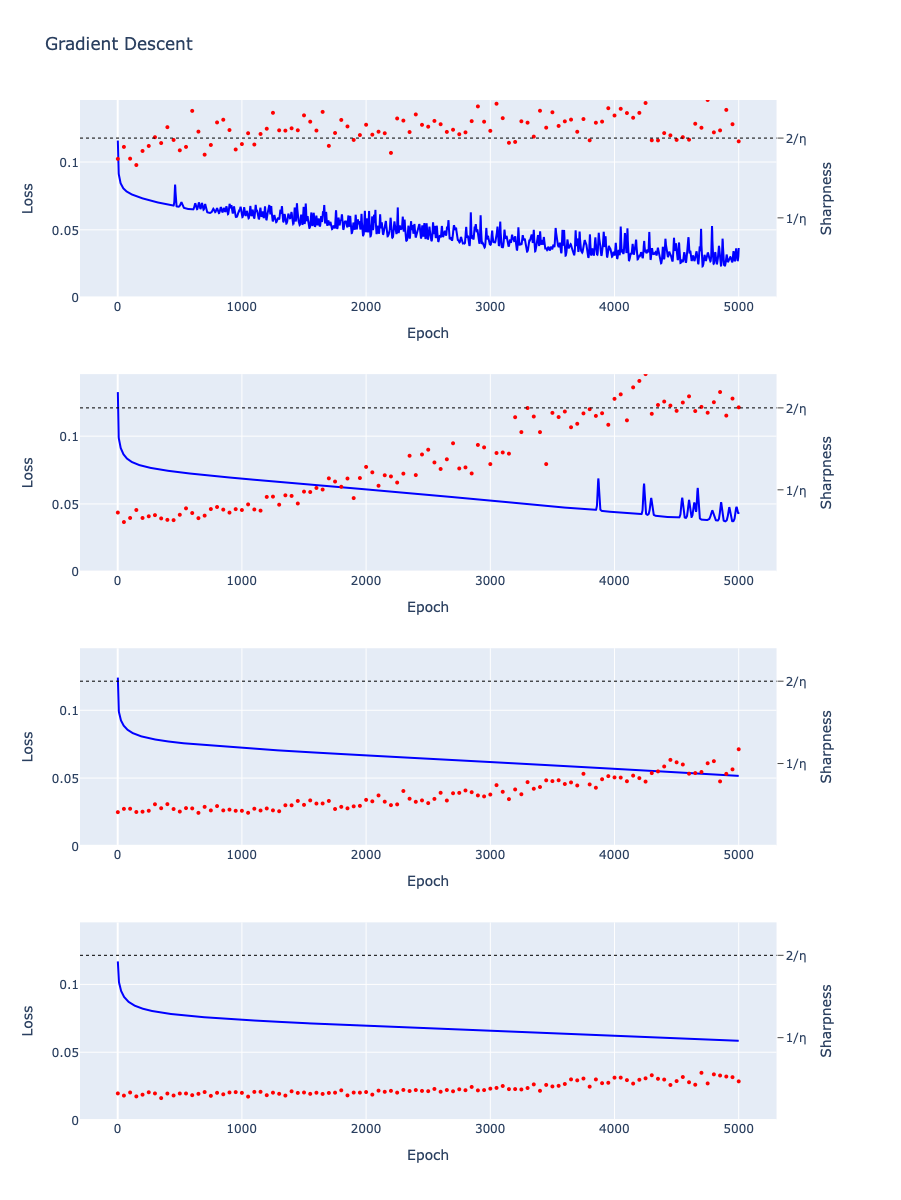

In [30]:
def plot_output_data(metadata, output_data, num_rows, num_cols, title, model_ids = []):

    if len(model_ids) == 0:
        model_ids = metadata['model_id'].unique()

    specs = [[{"secondary_y": True} for _ in range(num_cols)] for _ in range(num_rows)]
    fig = make_subplots(num_rows, num_cols, specs=specs)

    for i, model_id in enumerate(model_ids):
        row = i // num_cols + 1
        col = i % num_cols + 1

        model_data = output_data[output_data['model_id'] == model_id]
        model_info = metadata[metadata['model_id'] == model_id].iloc[0]
        
        threshold = 2 / model_info['learning_rate']
        
        x_vals = np.arange(1, len(model_data)+1)
        loss = model_data['loss']
        sharpness = model_data['sharpness']

        fig.add_trace(
            go.Scatter(x=x_vals, y=loss, mode='lines', name='Loss',
                       line=dict(color='blue')),
            row=row, col=col, secondary_y=False
        )

        fig.add_trace(
            go.Scatter(x=x_vals, y=sharpness, mode='markers', name='Sharpness', 
                       marker=dict(size=4, color='red')),
            row=row, col=col, secondary_y=True
        )

        fig.add_hline(
            y=threshold,
            row=row, col=col,
            secondary_y=True,
            line=dict(color='black', dash='dot', width=1),
            opacity=1.0
        )

        fig.update_xaxes(title_text="Epoch", row=row, col=col)
        fig.update_yaxes(title_text="Loss", row=row, col=col, secondary_y=False,
            range=[0, output_data["loss"].max() * 1.1])
        fig.update_yaxes(title_text="Sharpness",row = row, col = col, secondary_y=True,
            range=[0,max(sharpness.max(), threshold * 1.2)],
            showgrid=False,
            tickmode='array',
            tickvals=[threshold / 2, threshold],
            ticktext=["1/η", "2/η"],
            ticks='outside',
            ticklen=6,
            tickwidth=1,
        )

    fig.update_layout(title_text=title, showlegend=False, height = 1200, width = 600)

    fig.show()

metadata, output_data = load_output_files()
plot_output_data(metadata, output_data, 4, 1, title="Gradient Descent")